# Train a Bird Classification Model
Follow steps below to get started with a jupyter notebook for how to train a Towhee operator. This example fine-tunes a pretrained ResNet model (eg. resnet-34 pretrained by ImageNet) with a bird dataset.
# 1. Download Operator
Download operator files together with the jupyter notebook.

In [1]:
! git clone https://towhee.io/towhee/resnet-image-embedding.git
%cd resnet-image-embedding
%ls

Cloning into 'resnet-image-embedding'...
remote: Enumerating objects: 220, done.
remote: Counting objects: 100% (220/220), done.
remote: Compressing objects: 100% (212/212), done.
remote: Total 220 (delta 119), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (220/220), 908.00 KiB | 358.00 KiB/s, done.
Resolving deltas: 100% (119/119), done.
/media/supermicro/DATA1/zhangchen_workspace/towhee_examples/resnet-image-embedding
examples/                     requirements.txt
ILSVRC2012_val_00049771.JPEG  resnet_image_embedding.py
__init__.py                   resnet_image_embedding.yaml
README.md                     resnet_training_yaml.yaml


Then run Python scripts in following steps to train and test a Towhee operator.
# 2. Setup Operator
Create operator and load model by name.

In [2]:
# import sys
# sys.path.append('..')
from resnet_image_embedding import ResnetImageEmbedding

# Set num_classes=400 for ResNet34 model (400 classes of birds in total)
op = ResnetImageEmbedding('resnet34', num_classes=400)

# 3. Configure Trainer:
Modify training configurations on top of default values.

In [3]:
from towhee.trainer.training_config import TrainingConfig

training_config = TrainingConfig()
training_config.batch_size = 32
training_config.epoch_num = 2
training_config.output_dir = 'bird_output'

# 4. Prepare Dataset
Download [BIRDS 400](https://www.kaggle.com/gpiosenka/100-bird-species) from Kaggle Dataset. And then create the dataset with local path and transform.


In [4]:
import os
from torchvision import transforms
from torchvision.datasets import ImageFolder

bird_400_path = '/home/zhangchen/zhangchen_workspace/dataset/bird_400'
# bird_400_path = '/path/to/your/dataset/bird_400/'

std = (0.229, 0.224, 0.229)
mean = (0.485, 0.456, 0.406)
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=mean, std=std),
                                transforms.RandomHorizontalFlip(p=0.5)
                               ])
train_data = ImageFolder(os.path.join(bird_400_path, 'train'), transform=transform)
eval_data = ImageFolder(os.path.join(bird_400_path, 'valid'), transform=transform)

# Start Training
Now start training the operator with Bird-400 dataset.

In [5]:
op.train(training_config, train_dataset=train_data, eval_dataset=eval_data)

2022-03-23 14:22:28,045 - 139813583537984 - trainer.py-trainer:319 - WARNING: TrainingConfig(output_dir='bird_output', overwrite_output_dir=True, eval_strategy='epoch', eval_steps=None, batch_size=32, val_batch_size=-1, seed=42, epoch_num=2, dataloader_pin_memory=True, dataloader_drop_last=True, dataloader_num_workers=0, lr=5e-05, metric='Accuracy', print_steps=None, load_best_model_at_end=False, early_stopping={'monitor': 'eval_epoch_metric', 'patience': 4, 'mode': 'max'}, model_checkpoint={'every_n_epoch': 1}, tensorboard={'log_dir': None, 'comment': ''}, loss='CrossEntropyLoss', optimizer='Adam', lr_scheduler_type='linear', warmup_ratio=0.0, warmup_steps=0, device_str=None, sync_bn=False, freeze_bn=False)
[epoch 1/2] loss=2.161, metric=0.675, eval_loss=2.138, eval_metric=0.942: 100%|█████████████████████████████████████████████████| 1824/1824 [03:48<00:00,  7.98step/s]
[epoch 2/2] loss=0.368, metric=0.939, eval_loss=0.389, eval_metric=0.968: 100%|████████████████████████████████████

# 6. Predict
With the fine-tuned model, you can then use the operator to classify a bird picture.

2022-03-23 14:32:26,135 - 139813583537984 - image.py-image:725 - WARNING: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


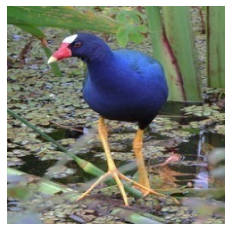

It is purple gallinule.
probability = 0.833383321762085


In [9]:
from towhee.trainer.utils.visualization import predict_image_classification
import random
import matplotlib.pyplot as plt

img_index = random.randint(0, len(eval_data))
img = eval_data[img_index][0]
img_np = img.numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)
img_np = img_np * std + mean
plt.axis('off')
plt.imshow(img_np)
plt.show()
img_tensor = eval_data[img_index][0].unsqueeze(0).to(op.trainer.configs.device)

prediction_score, pred_label_idx = predict_image_classification(op.model, img_tensor)
print('It is {}.'.format(eval_data.classes[pred_label_idx].lower()))
print('probability = {}'.format(prediction_score))